## Import Libraries 

In [14]:
import pandas as pd  # Import pandas library for data manipulation and analysis
import numpy as np  # Import numpy library for numerical computing
import math, random  # Import math and random modules for mathematical operations and random number generation
import librosa  # Import librosa library for audio analysis and processing
import glob  # Import glob module for finding files and directories based on wildcard patterns
import torch  # Import torch library for deep learning tasks
import torchaudio  # Import torchaudio library for audio processing

import csv  # Import csv module for reading and writing CSV files
import io  # Import io module for working with input and output streams
import torch.nn as nn  # Import nn module from torch library for neural network-related classes and functions

from torchaudio import transforms  # Import transforms module from torchaudio library for audio transformations
from IPython.display import Audio  # Import Audio class from IPython.display module for playing audio
from pathlib import Path  # Import Path class from pathlib module for working with file paths and directories
from sklearn import preprocessing  # Import preprocessing module from sklearn library for data preprocessing
from torch.nn import init  # Import init module from torch.nn package for weight initialization
from torch.utils.data import DataLoader, Dataset, random_split  # Import DataLoader, Dataset, and random_split classes from torch.utils.data module for data loading and dataset management


## Setup dataframe + Exploratory analysis

In [43]:
# Read the CSV file "train_metadata.csv" and assign the data to the variable df
df = pd.read_csv("/kaggle/input/birdclef-2023/train_metadata.csv")

In [44]:
# Display the first few rows of the DataFrame
print("DataFrame Preview:")
print(df.head())

# Check the dimensions of the DataFrame (number of rows, number of columns)
print("DataFrame Dimensions:")
print(df.shape)

# Check the column names and their data types
print("Column Names and Data Types:")
print(df.dtypes)

# Check for missing values in each column
print("Missing Values:")
print(df.isnull().sum())

# Check the unique values in the 'primary_label' column
print("Unique Labels:")
print(df['primary_label'].unique())


DataFrame Preview:
  primary_label secondary_labels              type  latitude  longitude  \
0       abethr1               []          ['song']    4.3906    38.2788   
1       abethr1               []          ['call']   -2.9524    38.2921   
2       abethr1               []          ['song']   -2.9524    38.2921   
3       abethr1               []          ['song']   -2.9524    38.2921   
4       abethr1               []  ['call', 'song']   -2.9524    38.2921   

      scientific_name               common_name         author  \
0  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   
1  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
2  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
3  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
4  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     4.0   
1  Cr

In [51]:
# Statistical Summary
df_summary =df.describe()
print(df_summary)

           latitude     longitude        rating
count  16714.000000  16714.000000  16941.000000
mean      12.599897     22.035690      3.727732
std       29.208254     28.743382      1.101060
min      -38.116900   -157.819400      0.000000
25%       -6.256000      5.941125      3.000000
50%        2.359500     26.750650      4.000000
75%       42.787100     36.589850      4.500000
max       71.976900    177.684900      5.000000


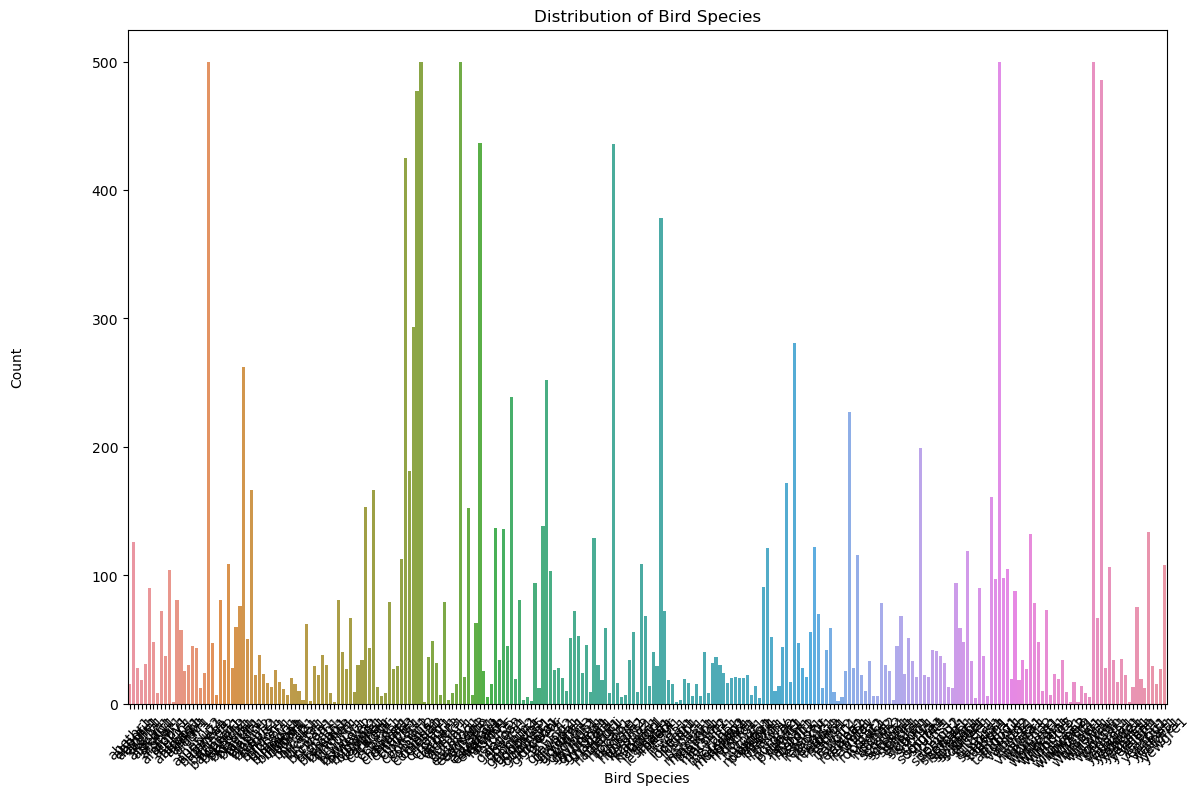

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Increase the figure size for better visibility

ax = sns.countplot(x='primary_label', data=df)
ax.set_xlabel('Bird Species')
ax.set_ylabel('Count')
ax.set_title('Distribution of Bird Species')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle to prevent overlapping

# Move the x-axis label to the side
ax.xaxis.set_label_coords(0.5, -0.1)

# Move the y-axis label to the side
ax.yaxis.set_label_coords(-0.1, 0.5)

plt.tight_layout()  # Ensure all elements fit within the plot area
plt.show()

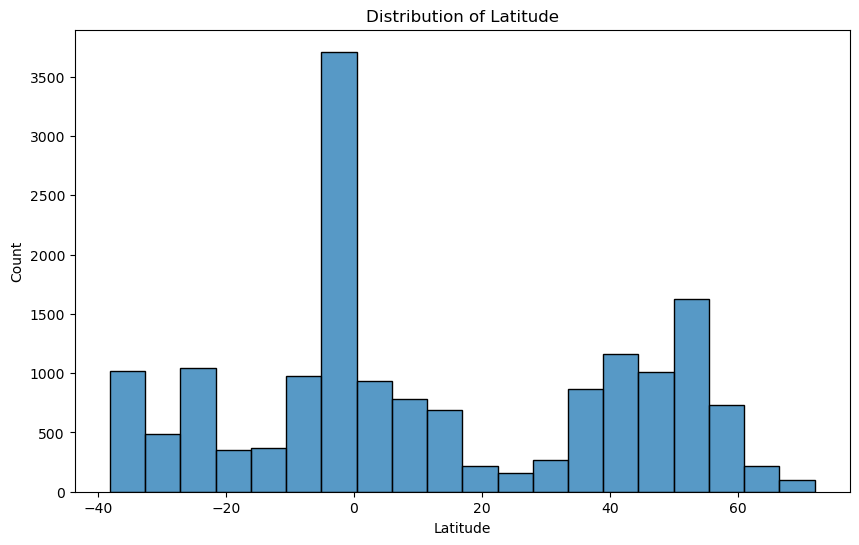

In [53]:
# Visualizing Numeric Variables
plt.figure(figsize=(10, 6))
sns.histplot(x='latitude', data=df, bins=20)
plt.xlabel('Latitude')
plt.ylabel('Count')
plt.title('Distribution of Latitude')
plt.show()

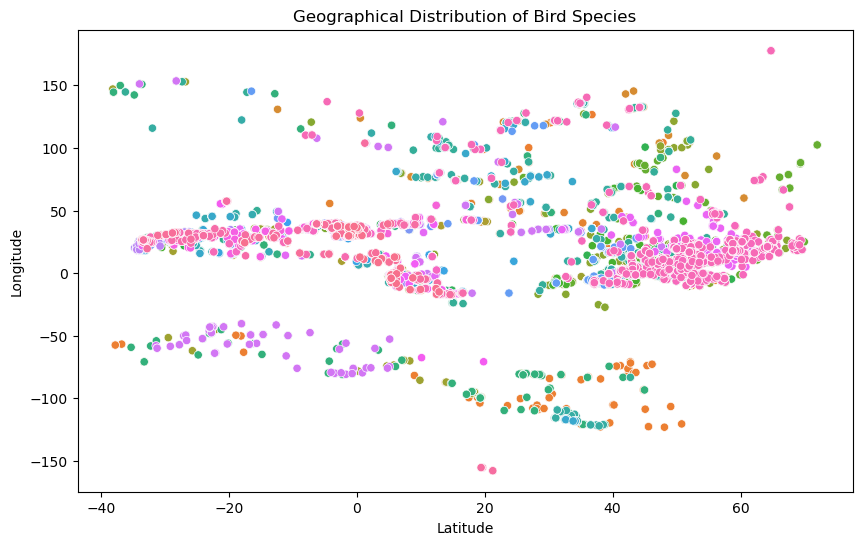

In [54]:
# Exploring Relationships
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latitude', y='longitude', data=df, hue='primary_label', legend=False)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Geographical Distribution of Bird Species')
plt.show()

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


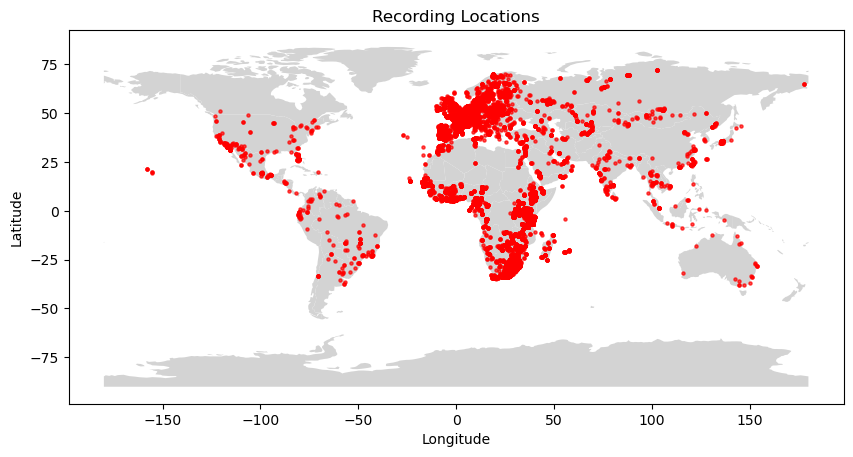

In [55]:
# Geospatial Analysis
import geopandas as gpd
from shapely.geometry import Point

# Create a GeoDataFrame with latitude and longitude
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Plot the recording locations on a map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax, color='lightgray')
gdf.plot(ax=ax, markersize=5, color='red', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Recording Locations')
plt.show()

In [56]:
# Peprocess the data by creating a new column for the relative path of audio files, selecting relevant columns, encoding the class labels, and organizing the DataFrame for model training.
# Create a new column 'relative_path' by concatenating 'train_audio/' with 'filename'
df['relative_path'] = 'train_audio/' + df['filename'].astype(str)

# Select only the 'relative_path' and 'primary_label' columns
df = df[['relative_path', 'primary_label']]

# Get the unique classes from the 'primary_label' column and sort them
classes = sorted(df.primary_label.unique())

# Encode the 'primary_label' column to numerical class labels using LabelEncoder
le = preprocessing.LabelEncoder()
df[['classID']] = df[['primary_label']].apply(le.fit_transform)

# Delete the 'primary_label' column from the DataFrame
del df['primary_label']

## Cleaning Data

In [57]:
# Detect and handle duplicate rows
duplicate_rows = df.duplicated()
if duplicate_rows.any():
    # Display the duplicate rows
    print("Duplicate rows:")
    print(df[duplicate_rows])
    # Drop the duplicate rows
    df = df.drop_duplicates()
# Removing outliers in the 'relative_path' column
df = df[(df['relative_path'] != 'train_audio/outlier1.wav') & (df['relative_path'] != 'train_audio/outlier2.wav')]

# Correcting inconsistent values in the 'classID' column
df.loc[df['classID'] == 10, 'classID'] = 5

# Standardizing formats in the 'relative_path' column
df['relative_path'] = df['relative_path'].str.replace('\\', '/', regex=False)

## Mapping the classes and counting the unsupported classes

In [40]:
# Create a list of classes that match the encoded class labels
competition_classes = classes

# Count the number of classes that are not supported by the pretrained model
forced_defaults = 0
competition_class_map = []
for c in competition_classes:
    try:
        i = classes.index(c)
        competition_class_map.append(i)
    except:
        competition_class_map.append(0)
        forced_defaults += 1

# Print the count of classes not supported by the pretrained model
forced_defaults

0

## Preprocess the data

In [58]:
# Framing a given signal into smaller overlapping frames
import torch.nn.functional as F  

def frame(signal, frame_length, frame_step, pad_end=False, pad_value=1000, axis=-1):
    """
    equivalent of tf.signal.frame
    """
    signal_length = signal.shape[axis]  # Get the length of the 'signal' along the specified 'axis'
    
    if pad_end:
        frames_overlap = frame_length - frame_step  # Calculate the number of overlapping samples between frames
        rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)  # Calculate the remaining samples after framing
        pad_size = int(frame_length - rest_samples)  # Calculate the size of padding needed
        if pad_size != 0:  # If padding is required
            pad_axis = [0] * signal.ndim  # Create a list for padding axes
            pad_axis[axis] = pad_size  # Set the size of padding along the specified 'axis'
            # Calculate the padding size needed for both ends
            left_pad = pad_size // 2
            right_pad = pad_size - left_pad
            signal = F.pad(signal, (left_pad, right_pad), "constant", pad_value)  # Apply padding to the signal using 'F.pad' function
    
    frames = signal.unfold(axis, frame_length, frame_step)  # Unfold the 'signal' tensor to extract overlapping frames
    
    return frames  # Return the 'frames' tensor representing the framed signal


In [60]:
# framing audio signals
def frame_audio(audio_array: np.ndarray, window_size_s: float = 5.0, hop_size_s: float = 5.0, sample_rate=32000) -> np.ndarray:
    """Helper function for framing audio for inference."""

    if window_size_s is None or window_size_s < 0:
        # If window_size_s is None or negative, return audio_array with an additional axis
        return audio_array[np.newaxis, :]

    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    max_len = sample_rate // 1000 * window_size_s

    framed_audio = frame(audio_array, frame_length, hop_length, pad_value=max_len, pad_end=True)
    # Frame the audio_array using the specified frame_length, hop_length, and pad_value.
    # The pad_end parameter is set to True to pad the end of the audio if necessary.
    return framed_audio

In [61]:
# Checks if the original_sample_rate matches the desired_sample_rate. 
def ensure_sample_rate(waveform, original_sample_rate, desired_sample_rate=32000):
    """Resample waveform if required."""
    if original_sample_rate != desired_sample_rate:
        # Convert the NumPy array to a PyTorch tensor with a floating-point data type
        audio_tensor = torch.from_numpy(waveform).float()

        # Resample the waveform using torchaudio.transforms.Resample
        waveform = torchaudio.transforms.Resample(original_sample_rate, desired_sample_rate)(audio_tensor)

    return desired_sample_rate, waveform


# Examples

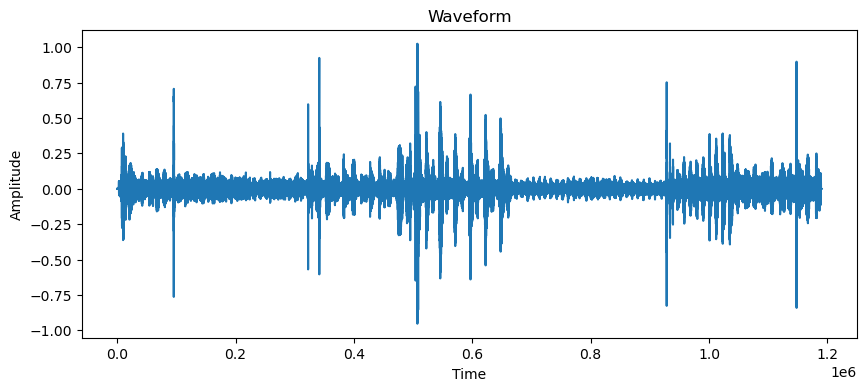

In [115]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

# Load the audio file using librosa and obtain the audio data and sample rate
audio0, sample_rate = librosa.load("/kaggle/input/birdclef-2023/train_audio/afghor1/XC156639.ogg")

# Ensure that the sample rate of the audio matches the desired sample rate
sample_rate, wav_data = ensure_sample_rate(audio0, sample_rate)

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(wav_data)
plt.title('Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Display the audio data as an audio widget
Audio(wav_data, rate=sample_rate)


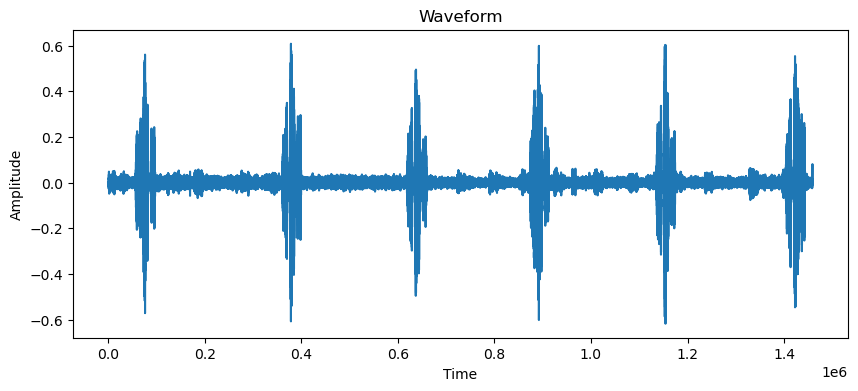

In [116]:
# Load the audio file using librosa and obtain the audio data and sample rate
audio1, sample_rate = librosa.load("/kaggle/input/birdclef-2023/train_audio/abethr1/XC128013.ogg")

# Ensure that the sample rate of the audio matches the desired sample rate
sample_rate, wav_data = ensure_sample_rate(audio1, sample_rate)

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(wav_data)
plt.title('Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Display the audio data as an audio widget
Audio(wav_data, rate=sample_rate)


##  Model

In [79]:
class AudioUtil():
  # Load an audio file. Return the signal as a tensor and the sample rate
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  # Convert the given audio to the desired number of channels
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

  # Resample the audio to the desired sample rate
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample the first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1, :])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:, :])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  # Pad or truncate the audio signal to a fixed length
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr // 1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:, :max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  # Shifts the audio signal to the left or right by some percent
  @staticmethod
  def time_shift(aud, shift_limit):
    sig, sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  # Generate a spectrogram from the audio signal
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, sr = aud
    top_db = 80

    # Compute the Mel spectrogram
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  # Augment the spectrogram by masking out sections to prevent overfitting
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [81]:
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
    
  def __len__(self):
    return len(self.df) 

  def __getitem__(self, idx):
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    class_id = self.df.loc[idx, 'classID']
   
    # Load the audio file and get the signal and sample rate
    aud = AudioUtil.open(audio_file)
    
    # Resample the audio to the desired sample rate
    reaud = AudioUtil.resample(aud, self.sr)
    
    # Convert the audio to the desired number of channels
    rechan = AudioUtil.rechannel(reaud, self.channel)
    
    # Pad or truncate the audio signal to a fixed duration
    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    
    # Shift the audio signal by a random percentage
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    
    # Generate a spectrogram from the shifted audio signal
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    
    # Augment the spectrogram by applying frequency and time masking
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [83]:
import torch
import torch.nn as nn
import torch.nn.init as init

class AudioClassifier(nn.Module):
    # Build the model architecture
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=264)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # Forward pass computations
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        return x

In [86]:
# Set the data path by concatenating the download path and a directory name
data_path = download_path + 'birdclef-2023/'

# Create a SoundDS object by passing the dataframe and data path as arguments
myds = SoundDS(df, data_path)

# Calculate the total number of items in the dataset
num_items = len(myds)

# Determine the number of items for training and validation based on an 80:20 split ratio
num_train = round(num_items * 0.8)
num_val = num_items - num_train

# Split the dataset into training and validation sets using random_split function from PyTorch
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create a data loader for the training set, with a batch size of 16 and shuffling the data
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)

# Create a data loader for the validation set, with a batch size of 16 and no shuffling
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [87]:
# Set the dataset to the training dataset
dataset = train_ds

# Iterate through the dataset
for i in range(10):
    # Get the i-th sample from the dataset
    sample = dataset[i]

    # Extract the input (audio data) and target (label) from the sample
    input, target = sample

    # Do something with the input and target
    print(f'Sample {i}: Input shape: {input.shape}, Target: {target}')


Sample 0: Input shape: torch.Size([2, 64, 344]), Target: 63
Sample 1: Input shape: torch.Size([2, 64, 344]), Target: 29
Sample 2: Input shape: torch.Size([2, 64, 344]), Target: 74
Sample 3: Input shape: torch.Size([2, 64, 344]), Target: 70
Sample 4: Input shape: torch.Size([2, 64, 344]), Target: 24
Sample 5: Input shape: torch.Size([2, 64, 344]), Target: 8
Sample 6: Input shape: torch.Size([2, 64, 344]), Target: 72
Sample 7: Input shape: torch.Size([2, 64, 344]), Target: 72
Sample 8: Input shape: torch.Size([2, 64, 344]), Target: 84
Sample 9: Input shape: torch.Size([2, 64, 344]), Target: 259


In [90]:
# Create an instance of the AudioClassifier model
audioModel = AudioClassifier()

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the audioModel to the selected device
audioModel = audioModel.to(device)

# Get the device of the first parameter of the audioModel
model_device = next(audioModel.parameters()).device

## Train the Model

In [91]:
import gc
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        if i % 10 == 0:    # print every 10 mini-batches
           print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  
num_epochs=2   # Just for demo, adjust this higher.
training(audioModel, train_dl, num_epochs)
#23/03
#Epoch: 0, Loss: 5.18, Accuracy: 0.04
#Epoch: 1, Loss: 4.56, Accuracy: 0.09
gc.collect()
torch.cuda.empty_cache()

[1,     1] loss: 0.558
[1,    11] loss: 6.155
[1,    21] loss: 11.770
[1,    31] loss: 17.362
[1,    41] loss: 22.947
[1,    51] loss: 28.512
[1,    61] loss: 34.085
[1,    71] loss: 39.675
[1,    81] loss: 45.266
[1,    91] loss: 50.836
[1,   101] loss: 56.388
[1,   111] loss: 61.931
[1,   121] loss: 67.493
[1,   131] loss: 73.035
[1,   141] loss: 78.612
[1,   151] loss: 84.148
[1,   161] loss: 89.676
[1,   171] loss: 95.228
[1,   181] loss: 100.740
[1,   191] loss: 106.293
[1,   201] loss: 111.782
[1,   211] loss: 117.286
[1,   221] loss: 122.768
[1,   231] loss: 128.272
[1,   241] loss: 133.758
[1,   251] loss: 139.181
[1,   261] loss: 144.681
[1,   271] loss: 150.149
[1,   281] loss: 155.573
[1,   291] loss: 161.000
[1,   301] loss: 166.432
[1,   311] loss: 171.823
[1,   321] loss: 177.237
[1,   331] loss: 182.642
[1,   341] loss: 187.975
[1,   351] loss: 193.317
[1,   361] loss: 198.720
[1,   371] loss: 204.075
[1,   381] loss: 209.342
[1,   391] loss: 214.636
[1,   401] loss: 219

## Predictions

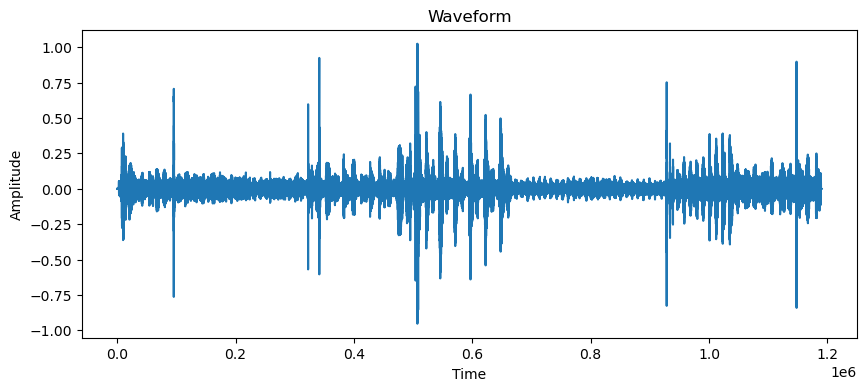

In [117]:
import librosa
# Load the audio file using librosa and obtain the audio data and sample rate
audio0, sample_rate = librosa.load("/kaggle/input/birdclef-2023/train_audio/afghor1/XC156639.ogg")

# Ensure that the sample rate of the audio matches the desired sample rate
sample_rate, wav_data = ensure_sample_rate(audio0, sample_rate)

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(wav_data)
plt.title('Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
# Frame the audio data
fixed_tm = frame_audio(wav_data)


In [94]:
def audio_transform(aud, sr, channel, duration, shift_pct):
    # Resample the audio to a desired sample rate
    reaud = AudioUtil.resample(aud, sr)
    
    # Rechannel the audio to a specific channel
    rechan = AudioUtil.rechannel(reaud, channel)
    
    # Pad or truncate the audio to a specified duration
    dur_aud = AudioUtil.pad_trunc(rechan, duration)
    
    # Apply a time shift to the audio
    shift_aud = AudioUtil.time_shift(dur_aud, shift_pct)
    
    # Compute the spectrogram of the shifted audio
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    
    # Apply spectrogram augmentation, such as frequency and time masking
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram

In [95]:
# Call the audio_transform function with the given arguments
# The audio_transform function expects a tuple (aud, sr) as the aud parameter, where aud represents the audio data and sr represents the sample rate
# The audio data is taken from the first element of the fixed_tm array and the sample rate is provided in the sample_rate variable
# The other arguments are set as follows: 44100 for sr (resampled sample rate), 2 for channel (number of audio channels), 4000 for duration (desired duration in milliseconds), and 0.4 for shift_pct (percentage of time shift)
# The audio_transform function performs various transformations on the audio data
# It resamples the audio, rechannels it, pads or truncates it to the desired duration, applies a time shift, computes the spectrogram using mel frequency bands, and applies spectrogram augmentation
# The resulting augmented spectrogram is assigned to the inputs variable
inputs = audio_transform((fixed_tm[:1], sample_rate), 44100, 2, 4000, 0.4)


In [96]:
# Get the shape of the sliced array fixed_tm[:1]
# The [:1] slice selects the first element from the fixed_tm array
# The shape of the selected element is obtained using the shape attribute
fixed_tm_shape = fixed_tm[:1].shape

# Get the shape of the inputs array
# The shape attribute returns the shape of the inputs array
inputs_shape = inputs.shape

# Get the shape of the tensor obtained by unsqueezing the second element of inputs
# The unsqueeze(0) function adds a dimension of size 1 at the specified position (0 in this case)
# The shape attribute is used to obtain the shape of the resulting tensor
unsqueezed_shape = inputs[1].unsqueeze(0).shape


In [98]:
# Add a dimension of size 0 to the inputs tensor using unsqueeze(0) function
# This is done to match the expected input shape for the audioModel
# The unsqueezed tensor will have a shape of (1, num_channels, num_frames, num_features)
inputs_unsqueezed = inputs.unsqueeze(0)

# Pass the unsqueezed inputs tensor to the audioModel for prediction
# The outputs tensor will contain the predicted output from the model
outputs = audioModel(inputs_unsqueezed)

In [99]:
# Get the shape of the fixed_tm tensor
# The shape represents the dimensions of the tensor
fixed_tm_shape = fixed_tm.shape

# Print the shape of fixed_tm
print(fixed_tm_shape)

torch.Size([8, 160000])


In [100]:
# Open the audio file
aud = AudioUtil.open("/kaggle/input/birdclef-2023/train_audio/afghor1/XC156639.ogg")

# Preprocess the audio data
inputs = audio_transform(aud, 44100, 2, 4000, 0.4, 15)

# Pass the preprocessed data to the model for prediction
outputs = audioModel(inputs[0:2].unsqueeze(0))

# Convert the model outputs to probabilities using the sigmoid function
probabilities = outputs.sigmoid().cpu().detach().numpy()

# Find the index of the predicted bird species with the highest probability
argmax = np.argmax(probabilities)

# Print the predicted bird species, its class label, and the probability
print(f"The audio is from the class {classes[argmax]} (element:{argmax} in the label.csv file), with probability of {probabilities[0][argmax]}")

The audio is from the class thrnig1 (element:221 in the label.csv file), with probability of 0.878097653388977


In [102]:
def predict_for_sample(filename, sample_submission, frame_limit_secs=None):
    # Extract the file ID from the filename
    file_id = filename.split(".ogg")[0].split("/")[-1]
    
    # Load the audio file and ensure the sample rate is correct
    audio, sample_rate = librosa.load(filename)
    sample_rate, wav_data = ensure_sample_rate(audio, sample_rate)
    
    # Frame the audio data
    fixed_tm = frame_audio(wav_data)
    
    # Transform the input audio data
    inputs = audio_transform((fixed_tm[:1], sample_rate), 44100, 2, 4000, 0.4)
    
    # Set the initial frame number
    frame = 5
    
    # Perform inference on the initial input
    all_logits = audioModel(inputs.unsqueeze(0)).cpu().detach().numpy()
    
    # Iterate over the remaining frames
    for window in fixed_tm[1:]:
        # Check if the frame limit has been reached
        if frame_limit_secs and frame > frame_limit_secs:
            continue
        
        # Transform the input window
        inputs = audio_transform((window[np.newaxis, :], sample_rate), 44100, 2, 4000, 0.4)
        
        # Perform inference on the transformed input
        logits = audioModel(inputs.unsqueeze(0)).cpu().detach().numpy()
        
        # Concatenate the logits with previous results
        all_logits = np.concatenate([all_logits, logits], axis=0)
        
        # Increment the frame number
        frame += 5
    
    # Set the initial frame number
    frame = 5
    
    # Iterate over the logits and compute probabilities
    all_probabilities = []
    for frame_logits in all_logits:
        probabilities = torch.nn.functional.softmax(torch.from_numpy(frame_logits), dim=0).numpy()
        
        # Set the appropriate row in the sample submission
        sample_submission.loc[sample_submission.row_id == file_id + "_" + str(frame), competition_classes] = probabilities[competition_class_map]
        
        # Increment the frame number
        frame += 5

## Submission

In [103]:
# Get a list of paths for test audio samples
test_samples = list(glob.glob("/kaggle/input/birdclef-2023/test_soundscapes/*.ogg"))

# Print the list of test audio sample paths
test_samples

['/kaggle/input/birdclef-2023/test_soundscapes/soundscape_29201.ogg']

In [104]:
# Read the sample submission file into a DataFrame
sample_sub = pd.read_csv("/kaggle/input/birdclef-2023/sample_submission.csv")

# Convert the columns representing competition classes to float32 data type
sample_sub[competition_classes] = sample_sub[competition_classes].astype(np.float32)

# Display the first few rows of the DataFrame
sample_sub.head()


row_id  abethr1  abhori1  abythr1  afbfly1  afdfly1  afecuc1  \
0   soundscape_29201_5      0.0      0.0      0.0      0.0      0.0      0.0   
1  soundscape_29201_10      0.0      0.0      0.0      0.0      0.0      0.0   
2  soundscape_29201_15      0.0      0.0      0.0      0.0      0.0      0.0   

   affeag1  afgfly1  afghor1  ...  yebsto1  yeccan1  yefcan  yelbis1  yenspu1  \
0      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   
1      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   
2      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   

   yertin1  yesbar1  yespet1  yetgre1  yewgre1  
0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0  

[3 rows x 265 columns]

In [105]:
# Set the frame limit in seconds based on the number of rows in the sample submission
frame_limit_secs = 15 if sample_sub.shape[0] == 3 else None

# Iterate over each test sample filename
for sample_filename in test_samples:
    # Call the function to predict for each sample and update the sample submission DataFrame
    predict_for_sample(sample_filename, sample_sub, frame_limit_secs=15)

In [106]:
sample_sub

row_id   abethr1   abhori1   abythr1   afbfly1   afdfly1  \
0   soundscape_29201_5  0.000968  0.007461  0.001909  0.001257  0.001932   
1  soundscape_29201_10  0.000968  0.007461  0.001909  0.001257  0.001932   
2  soundscape_29201_15  0.000968  0.007461  0.001909  0.001257  0.001932   

    afecuc1   affeag1   afgfly1   afghor1  ...   yebsto1   yeccan1  yefcan  \
0  0.012593  0.003097  0.000699  0.003968  ...  0.000027  0.001071  0.0046   
1  0.012593  0.003097  0.000699  0.003968  ...  0.000027  0.001071  0.0046   
2  0.012593  0.003097  0.000699  0.003968  ...  0.000027  0.001071  0.0046   

    yelbis1   yenspu1   yertin1   yesbar1   yespet1   yetgre1   yewgre1  
0  0.001429  0.001194  0.007991  0.001791  0.000852  0.001617  0.006468  
1  0.001429  0.001194  0.007991  0.001791  0.000852  0.001617  0.006468  
2  0.001429  0.001194  0.007991  0.001791  0.000852  0.001617  0.006468  

[3 rows x 265 columns]